# Random forest

- Bias là sự sai khác giữa trung bình dự đoán của mô hình chúng ta xây dựng với giá trị chính xác đang cố gắng để dự đoán. Một mô hình với trị số bias cao đồng nghĩa với việc mô hình đó không quan tâm nhiều tới dữ liệu huấn luyện, khiến cho mô hình trở nên đơn giản quá. Nó thường dẫn đến việc mô hình có mức độ lỗi cao cả trên tập huấn luyện và tập kiểm thử.
- Variance đặc trưng cho mức độ tản mát của giá trị dự đoán cho điểm dữ liệu. Mô hình với mức độ variance cao tập trung chú ý nhiều vào dữ liệu huấn luyện và không mang được tính tổng quát trên dữ liệu chưa gặp bao giờ. Từ đó dẫn đến mô hình đạt được kết quả cực kì tốt trên tập dữ liệu huấn luyện, tuy nhiên kết quả rất tệ với tập dữ liệu kiểm thử.

- Ensemple learning
  - Bagging: xây dựng N cây sau đó tổng hợp thành 1 cây duy nhất (Strong classifier) - Random forest
  - Boosting: xây dựng cây N từ cây thứ N-1 để cải thiện độ chính xác của cây trước đó
  - Stacking: mỗi dataset sẽ sử dụng các giải thuật khác nhau để xử lý trước cho ra 1 đầu ra theo chuẩn mới để đưa vào mô hình huấn luyện
- Homogeneous Approach

- Xây dựng random forest
  - Lấy ngẫu nhiên n dữ liệu từ bộ dữ liệu với kĩ thuật $Bootstrapping$, hay còn gọi là random sampling with replacement. Tức khi mình sample được 1 dữ liệu thì mình không bỏ dữ liệu đấy ra mà vẫn giữ lại trong tập dữ liệu ban đầu, rồi tiếp tục sample cho tới khi sample đủ n dữ liệu. Khi dùng kĩ thuật này thì tập n dữ liệu mới của mình có thể có những dữ liệu bị trùng nhau.
  - Sau khi sample được n dữ liệu từ bước 1 thì mình chọn ngẫu nhiên ở k thuộc tính (k < n). Giờ mình được bộ dữ liệu mới gồm n dữ liệu và mỗi dữ liệu có k thuộc tính
  - Dùng thuật toán Decision Tree để xây dựng cây quyết định với bộ dữ liệu ở bước 2
  - Loại bỏ feature root node ra khỏi dataset và chọn ngẫu nhiên 2 feature còn lại và đánh giá lựa chọn root node
  - Tiếp tục quá trình đến khi hết feature
  - Xây dựng N tree song song như trên


## Tại sao thuật toán Random Forest tốt?

- Trong thuật toán Decision Tree, khi xây dựng cây quyết định nếu để độ sâu tùy ý thì cây sẽ phân loại đúng hết các dữ liệu trong tập training dẫn đến mô hình có thể dự đoán tệ trên tập validation/test, khi đó mô hình bị overfitting, hay nói cách khác là mô hình có high variance.

[Tham khảo]

## Random forest with missing data

- Khởi tạo giá trị ban đầu bằng trung bình, trung vị, voting của các sample để điền vào data missing
- Proximity matrix: để xác định số cây dự đoán giống nhau

In [24]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score

In [25]:
# Tính entropy
def entropy(s):
    counts = np.bincount(s)
    percentages = counts / len(s)

    entropy = 0
    for pct in percentages:
        if pct > 0:
            entropy += pct * np.log2(pct)
    return -entropy

In [26]:
# Kiểm tra
s = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
print(f'Entropy: {np.round(entropy(s), 2)}')

Entropy: 0.88


In [27]:
#Tính information gain
def information_gain(parent, left_child, right_child):
    num_left = len(left_child) / len(parent)
    num_right = len(right_child) / len(parent)

    gain = entropy(parent) - (num_left * entropy(left_child) + num_right * entropy(right_child))
    return gain

In [28]:
# Kiểm thử
parent = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
left_child = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
right_child = [0, 0, 0, 0, 1, 1, 1, 1]

print(f'Information gain: {np.round(information_gain(parent, left_child, right_child), 5)}')

Information gain: 0.18094


In [29]:
def factorial(x):
    # Exit condition
    if x == 1:
        return 1
    return x * factorial(x - 1)

print(f'Factorial of 5 is {factorial(5)}')

Factorial of 5 is 120


In [30]:
class AIONode:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None,
                 data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [31]:
class AIODecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.

        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy

    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.

        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)

        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))

    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target

        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape

        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split

    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.

        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape

        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1],
                    y=best['df_left'][:, -1],
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1],
                    y=best['df_right'][:, -1],
                    depth=depth + 1
                )
                return AIONode(
                    feature=best['feature_index'],
                    threshold=best['threshold'],
                    data_left=left,
                    data_right=right,
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value
        return AIONode(
            value=Counter(y).most_common(1)[0][0]
        )

    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.

        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)

    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).

        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]

        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)

        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)

    def predict(self, X):
        '''
        Function used to classify new instances.

        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [32]:
# Sử dụng Iris dataset từ Sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Đánh giá độ chính xác
model = AIODecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy_score(y_test, preds)

1.0

In [34]:
from sklearn.tree import DecisionTreeClassifier

# Đánh giá độ chính xác sử dụng thư viện Sklearn
sk_model = DecisionTreeClassifier()
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)
accuracy_score(y_test, sk_preds)

1.0

In [35]:
class AIORandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # Will store individually trained decision trees
        self.decision_trees = []

    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for boostrap sampling.

        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]

    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.

        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []

        # Build each tree of the forest
        num_built = 0
        while num_built < self.num_trees:
            try:
                clf = AIODecisionTree(
                    min_samples_split=self.min_samples_split,
                    max_depth=self.max_depth
                )
                # Obtain data sample
                _X, _y = self._sample(X, y)
                # Train
                clf.fit(_X, _y)
                # Save the classifier
                self.decision_trees.append(clf)
                num_built += 1
            except Exception as e:
                continue

    def predict(self, X):
        '''
        Predicts class labels for new data instances.

        :param X: np.array, new instances to predict
        :return:
        '''
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))

        # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)

        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            counter = Counter(preds)
            predictions.append(counter.most_common(1)[0][0])
        return predictions

In [36]:
# Load data từ Sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Đánh giá độ chính xác giải thuật random forest không dùng lib
model = AIORandomForest()
model.fit(X_train, y_train)
random_forest_preds = model.predict(X_test)
accuracy_score(y_test, random_forest_preds)

1.0

In [38]:
# Đánh giá độ chính xác giải thuật random forest
# sử dụng RandomForestClassifier class từ Sklearn
from sklearn.ensemble import RandomForestClassifier

sk_model = RandomForestClassifier()
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)
accuracy_score(y_test, sk_preds)

1.0

## Random forest for classification

In [39]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd

# load data
data = pd.read_csv('../data/iris_2D(1).csv')

# get x
x_data = data[['Petal_Length', 'Petal_Width']].to_numpy()
x_data = x_data.reshape(6, 2)
print(x_data)

[[1.  0.2]
 [1.3 0.6]
 [0.9 0.7]
 [1.7 0.5]
 [1.8 0.9]
 [1.2 1.3]]


In [40]:
y_train = np.array([0, 0, 0, 1, 1, 1]) 
print(y_train)

[0 0 0 1 1 1]


In [41]:
rf_classifier = RandomForestClassifier(n_estimators=3, 
                                      max_features=1,
                                      max_depth=1,
                                      criterion='entropy',
                                      max_samples=5)
rf_classifier.fit(x_data, y_train)
rf_classifier.predict(np.array([[2.7, 0.8]]))

array([1])

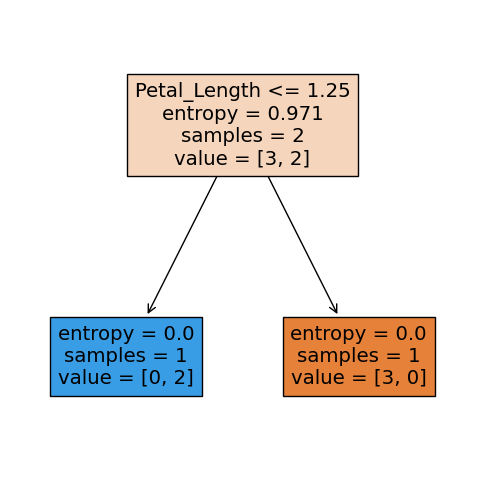

In [42]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(rf_classifier.estimators_[0], 
                   feature_names=['Petal_Length', 'Petal_Width'], 
                   filled=True)

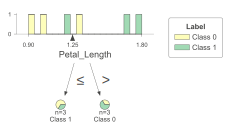

In [43]:
import dtreeviz

viz_model = dtreeviz.model(rf_classifier.estimators_[0],
                           X_train=x_data, y_train=y_train,
                           feature_names=['Petal_Length', 'Petal_Width'],
                           target_name='Label')

viz_model.view()

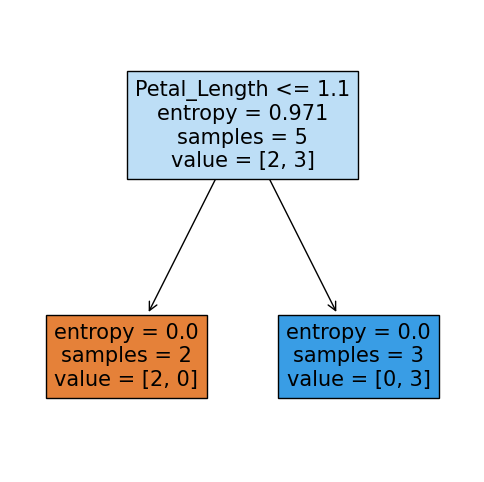

In [44]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(rf_classifier.estimators_[1], 
                   feature_names=['Petal_Length', 'Petal_Width'], 
                   filled=True)

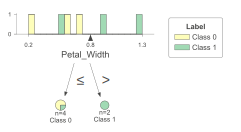

In [45]:
import dtreeviz

viz_model = dtreeviz.model(rf_classifier.estimators_[2],
                           X_train=x_data, y_train=y_train,
                           feature_names=['Petal_Length', 'Petal_Width'],
                           target_name='Label')

viz_model.view() 

## Random forest for regression

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib
from sklearn import tree

In [47]:
df = pd.read_csv('../data/Salary_Data_simple.csv')
df

,Experience,Salary
0,1.0,0.0
1,1.5,0.0
2,2.0,0.0
3,2.5,0.0
4,3.0,60.0
5,3.5,64.0
6,4.0,55.0
7,4.5,61.0
8,5.0,66.0
9,5.5,83.0


In [48]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
y_test

4    60.0
3     0.0
Name: Salary, dtype: float64

In [49]:
dt_regressor = RandomForestRegressor(n_estimators=3, 
                                     max_depth=2)
dt_regressor.fit(X, y)

RandomForestRegressor(max_depth=2, n_estimators=3)

In [50]:
y_pred = dt_regressor.predict(X_test)
y_pred

array([19.73333333,  0.        ])

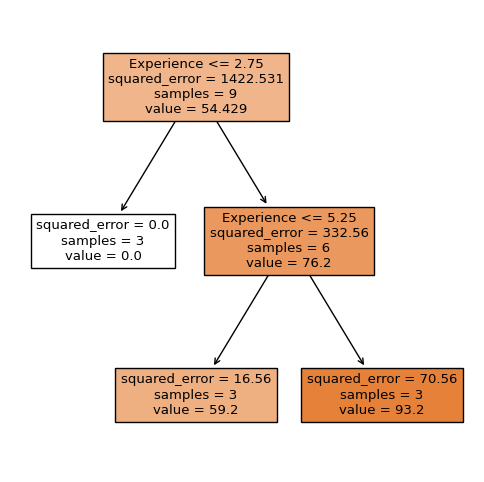

In [51]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(dt_regressor.estimators_[0], 
                   feature_names=['Experience'], 
                   filled=True)

In [52]:
viz = dtreeviz.model(dt_regressor.estimators_[0], 
                     X, y,
                     target_name="target",
                     feature_names=['YearsExperience'])
v = viz.view()     # render as SVG into internal object 
v.show()              # pop up window
v.save("iris.svg")

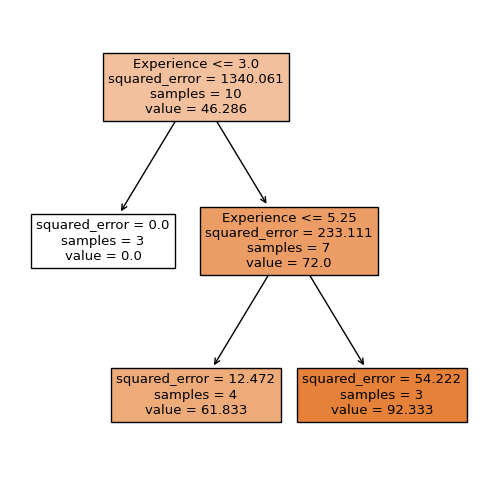

In [53]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(dt_regressor.estimators_[1], 
                   feature_names=['Experience'], 
                   filled=True)

In [54]:
import dtreeviz 

viz = dtreeviz.model(dt_regressor.estimators_[1], 
                     X, y,
                     target_name="target",
                     feature_names=['YearsExperience'])
v = viz.view()     # render as SVG into internal object 
v.show()              # pop up window
v.save("iris.svg")

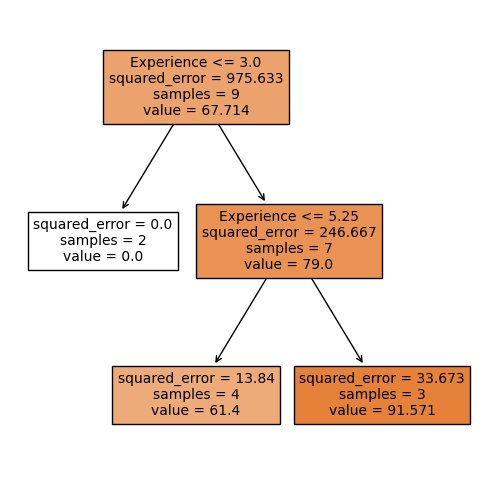

In [55]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(dt_regressor.estimators_[2], 
                   feature_names=['Experience'], 
                   filled=True)

In [56]:
import dtreeviz 

viz = dtreeviz.model(dt_regressor.estimators_[2], 
                     X, y,
                     target_name="target",
                     feature_names=['YearsExperience'])
v = viz.view()     # render as SVG into internal object 
v.show()              # pop up window
v.save("iris.svg")

In [57]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn import metrics

In [58]:
df=pd.read_csv("../data/Play Tennis.csv")
value=['Outlook','Temprature','Humidity','Wind']
df

,Day,Outlook,Temprature,Humidity,Wind,Play_Tennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
9,D10,Rain,Mild,Normal,Weak,Yes


In [59]:
from sklearn import preprocessing
string_to_int= preprocessing.LabelEncoder() #encode your data
df=df.apply(string_to_int.fit_transform) #fit and transform it
df

,Day,Outlook,Temprature,Humidity,Wind,Play_Tennis
0,0,2,1,0,1,0
1,6,2,1,0,0,0
2,7,0,1,0,1,1
3,8,1,2,0,1,1
4,9,1,0,1,1,1
5,10,1,0,1,0,0
6,11,0,0,1,0,1
7,12,2,2,0,1,0
8,13,2,0,1,1,1
9,1,1,2,1,1,1


In [60]:
#To divide our data into attribute set and Label:
feature_cols = ['Outlook','Temprature','Humidity','Wind']
X = df[feature_cols]
y = df.Play_Tennis

In [61]:
# perform training 
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(n_estimators=3, 
                                random_state=0)
classifier.fit(X, y)

c:\Users\vanna\.conda\envs\.env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.


AdaBoostClassifier(n_estimators=3, random_state=0)

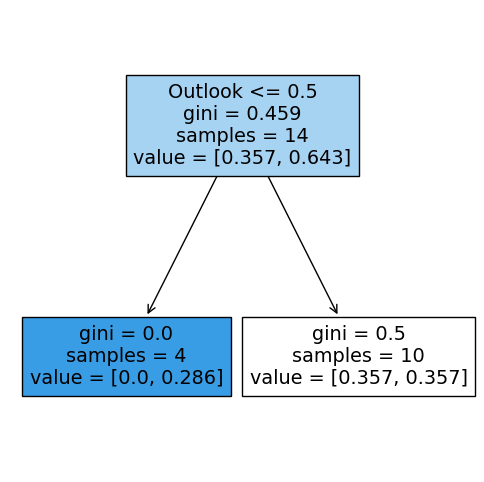

In [62]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(6,6))
_ = tree.plot_tree(classifier.estimators_[0], 
                   feature_names=feature_cols, 
                   filled=True)

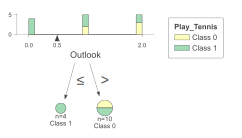

In [63]:
import dtreeviz

viz_model = dtreeviz.model(classifier.estimators_[0],
                           X_train=X, y_train=y,
                           feature_names=['Outlook','Temprature','Humidity','Wind'],
                           target_name='Play_Tennis')

viz_model.view()

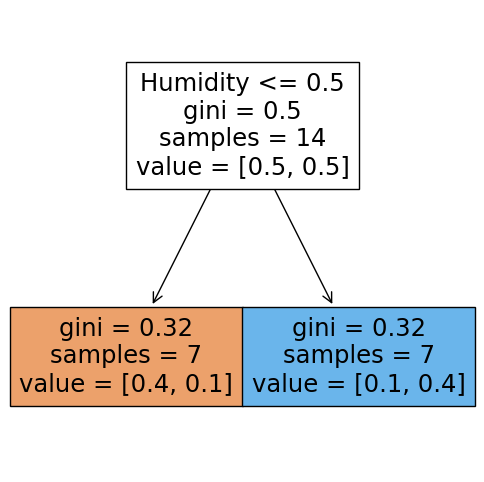

In [64]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(6,6))
_ = tree.plot_tree(classifier.estimators_[1], 
                   feature_names=feature_cols, 
                   filled=True)

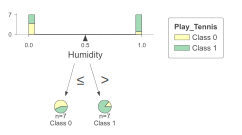

In [65]:
import dtreeviz

viz_model = dtreeviz.model(classifier.estimators_[1],
                           X_train=X, y_train=y,
                           feature_names=['Outlook','Temprature','Humidity','Wind'],
                           target_name='Play_Tennis')

viz_model.view()

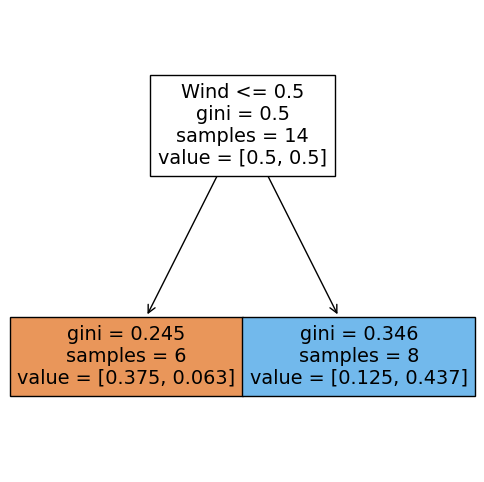

In [66]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(6,6))
_ = tree.plot_tree(classifier.estimators_[2], 
                   feature_names=feature_cols, 
                   filled=True)

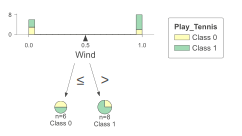

In [67]:
import dtreeviz

viz_model = dtreeviz.model(classifier.estimators_[2],
                           X_train=X, y_train=y,
                           feature_names=['Outlook','Temprature','Humidity','Wind'],
                           target_name='Play_Tennis')

viz_model.view()